<a href="https://colab.research.google.com/github/lygitdata/aml_project/blob/main/project1/code/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & import necessary libraries

In [1]:
pip install pyod -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pyod.models.ecod import ECOD
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor
from sklearn import ensemble, model_selection
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LassoCV
from sklearn.pipeline import make_pipeline, Pipeline
import lightgbm as lgb
import catboost as cb
import joblib

# Prepare data

## Helper functions

In [2]:
def impute_column_rf(df, target_col):
    """
    Imputation using random forest
    """
    pd.options.mode.chained_assignment = None
    df_complete = df[df[target_col].notnull()].copy()
    df_missing = df[df[target_col].isnull()].copy()

    if df_complete.empty or df_missing.empty:
        return df

    X_complete = df_complete.drop(columns=target_col)
    y_complete = df_complete[target_col]

    model = RandomForestRegressor(n_estimators=16, random_state=88, n_jobs=-1)
    model.fit(X_complete, y_complete)

    X_missing = df_missing.drop(columns=target_col)
    predictions = model.predict(X_missing)
    df.loc[df[target_col].isnull(), target_col] = predictions

    return df

def impute_column_KNN(df, n_neighbors=5):
    """
    Imputation using KNN
    """
    df_copy = df.copy()
    
    # Initialize KNNImputer with specified number of neighbors
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Apply KNN imputer to the DataFrame
    imputed_array = imputer.fit_transform(df_copy)
    
    # Convert the imputed array back to a DataFrame with original column names
    df_imputed = pd.DataFrame(imputed_array, columns=df_copy.columns)
    
    return df_imputed



def imput(train, test, strategy="median"):
    """
    Impute missing values in the training and test datasets.

    This function addresses missing values in the `train` and `test` datasets by applying the specified imputation strategy.
    It supports various methods, including "mean" and "median" (default), as well as "random_forest" for more advanced imputation.
    The function returns two DataFrames: the imputed training dataset and the imputed test dataset.

    :param train: Training dataset containing features and possibly missing values.
    :type train: pd.DataFrame
    :param test: Test dataset containing features and possibly missing values.
    :type test: pd.DataFrame
    :param strategy: Imputation strategy to use for missing values (default is "median"). Options include "mean", "median", and "random_forest".
    :type strategy: str
    :return: Tuple containing the imputed training and test datasets.
    :rtype: tuple of pd.DataFrame
    """
    if strategy == "random_forest":
      print("Use 'random_forest' to impute missing value.")
      for col in train.columns:
          if train[col].isnull().any():
              train_imputed = impute_column_rf(train, col)
      for col in test.columns:
          if test[col].isnull().any():
              test_imputed = impute_column_rf(test, col)
    elif strategy == "KNN":
      print("Use 'KNN' to impute missing value.")
      train_imputed = impute_column_KNN(train)
      test_imputed = impute_column_KNN(test)
    else:
      print("Use 'SimpleImputer' to impute missing value.")
      imputer = SimpleImputer(strategy=strategy)
      train_imputed = pd.DataFrame(
          imputer.fit_transform(train), columns=train.columns
      )
      test_imputed = pd.DataFrame(
          imputer.transform(test), columns=test.columns
      )
    
    return train_imputed, test_imputed



def outlier(X_train, y_train, contamination=0.01, verbose=False):
    """
    Remove outliers from training data using the ECOD (Empirical Cumulative Distribution) method.

    This function identifies and removes outliers from the training dataset based on the specified contamination
    rate using ECOD. It resets the index after removing outliers to ensure continuous row numbers.

    :param X_train: Training features.
    :type X_train: pd.DataFrame
    :param y_train: Training target labels.
    :type y_train: pd.DataFrame or pd.Series
    :param contamination: The proportion of outliers in the data (default is 0.01).
    :type contamination: float
    :param verbose: If True, prints the shapes of the resulting datasets after outlier removal (default is False).
    :type verbose: bool
    :return: Training features and labels after outlier removal.
    :rtype: tuple of pd.DataFrame
    """
    mask = (
        ECOD(contamination=contamination).fit(X_train, y_train).predict(X_train) != 1
    ).astype(int) == 1
    X_new = pd.DataFrame(X_train[mask]).reset_index(drop=True)
    y_new = pd.DataFrame(y_train[mask]).reset_index(drop=True)

    if verbose:
        print(
            f"The shape of X_train: {X_new.shape}. \nThe shape of y_train: {y_new.shape}."
        )

    return X_new, y_new


def xgb_feature_importance(
    n_estimators,
    early_stopping_rounds,
    X_train,
    y_train,
    n_splits,
    eval_metric,
    verbose=False,
):
    """
    Perform K-fold cross-validation and compute feature importance using XGBoost.

    This function trains an XGBoost model on multiple K-folds of the training data, calculates feature importance
    for each fold, and then aggregates the importance scores. Optionally, it can display a bar plot of the top features.

    :param n_estimators: Number of boosting rounds.
    :type n_estimators: int
    :param early_stopping_rounds: Number of rounds without improvement before stopping early.
    :type early_stopping_rounds: int
    :param X_train: Training features.
    :type X_train: pd.DataFrame
    :param y_train: Training target labels.
    :type y_train: pd.DataFrame or pd.Series
    :param n_splits: Number of cross-validation splits.
    :type n_splits: int
    :param eval_metric: Evaluation metric to optimize (e.g., "rmse").
    :type eval_metric: str
    :param verbose: If True, plots a bar chart of the top 50 feature importances (default is False).
    :type verbose: bool
    :return: A dictionary containing feature importance for each fold and cumulative importance.
    :rtype: dict
    """
    kf_xgb = KFold(n_splits=n_splits, shuffle=True, random_state=88)
    all_feature_dict = {}
    cumulative_importance = np.zeros(len(X_train.columns))
    fold_num = 1

    for train_index, val_index in kf_xgb.split(X_train):
        # Split the data into training and validation sets for this foldfscale
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Initialize and fit the XGBoost model
        xgb = XGBRegressor(
            n_estimators=n_estimators,
            random_state=88,
            eval_metric=eval_metric,
            early_stopping_rounds=early_stopping_rounds,
        )

        xgb.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False,
        )

        # Get feature importance for the current fold
        importances = xgb.feature_importances_

        # Accumulate the importance scores
        cumulative_importance += importances
        feature_importance_df = pd.DataFrame(
            {"Feature": X_train.columns, "Importance": importances}
        ).sort_values(by="Importance", ascending=False)
        all_feature_dict[f"fold{fold_num}"] = feature_importance_df

        fold_num += 1

    # After all folds, create a final DataFrame with summed feature importance
    final_feature_importance_df = pd.DataFrame(
        {"Feature": X_train.columns, "Importance": cumulative_importance}
    ).sort_values(by="Importance", ascending=False)

    if verbose:
        plt.figure(figsize=(8, 7))
        sns.barplot(
            x="Importance",
            y="Feature",
            hue="Feature",
            data=final_feature_importance_df[0:50],
            palette="viridis",
        )
        plt.xlabel("Cumulative Importance")
        plt.ylabel("Feature")
        plt.title("Top 50 Feature Importance from XGBoost Model")
        plt.tight_layout()
        plt.show()

    return {"each": all_feature_dict, "sum": final_feature_importance_df}


def xgb_feature_select(xgb_importance, X_train, X_test, adjust=1, criteria="mean", verbose=True):
    """
    Select features based on XGBoost feature importance.

    This function selects features from the training and test datasets based on the cumulative feature importance
    scores from the XGBoost model. You can choose to keep features with importance above the mean or median importance.

    :param xgb_importance: Dictionary containing feature importance results.
    :type xgb_importance: dict
    :param X_train: Training features.
    :type X_train: pd.DataFrame
    :param X_test: Test features.
    :type X_test: pd.DataFrame
    :param criteria: Criteria to select features, either 'mean' or 'median' (default is 'mean').
    :type criteria: str
    :param verbose: If True, prints the number of selected features (default is True).
    :type verbose: bool
    :return: Reduced training and test datasets with selected features.
    :rtype: tuple of pd.DataFrame
    """
    if criteria == "mean":
        selected_feature = np.array(
            xgb_importance["sum"]["Feature"][
                xgb_importance["sum"]["Importance"]
                >= np.mean(xgb_importance["sum"]["Importance"]) * adjust
            ]
        )
        if verbose:
            print(f"There are {len(selected_feature)} features selected.")
        X_train_new = X_train[selected_feature]
        X_test_new = X_test[selected_feature]
        return X_train_new, X_test_new
    elif criteria == "median":
        selected_feature = np.array(
            xgb_importance["sum"]["Feature"][
                xgb_importance["sum"]["Importance"]
                >= np.mean(xgb_importance["sum"]["Importance"]) * adjust
            ]
        )
        if verbose:
            print(f"There are {len(selected_feature)} features selected.")
        X_train_new = X_train[selected_feature]
        X_test_new = X_test[selected_feature]
        return X_train_new, X_test_new
    else:
        print("The `criteria` must be either 'mean' or 'median'.")


def preprocess(
    X_train,
    X_test,
    y_train,
    strategy="median",
    contamination=0.01,
    n_estimators=10,
    early_stopping_rounds=8,
    n_splits=10,
    eval_metric="rmse",
    criteria="mean",
    adjust=2,
    verbose=True,
):
    """
    Full data preprocessing pipeline including imputation, outlier removal, and feature selection.

    This function applies several steps to preprocess the data:
    - Imputes missing values
    - Removes outliers using the ECOD method
    - Computes feature importance using XGBoost
    - Selects features based on importance scores

    :param X_train: Training features.
    :type X_train: pd.DataFrame
    :param X_test: Test features.
    :type X_test: pd.DataFrame
    :param y_train: Training target labels.
    :type y_train: pd.DataFrame or pd.Series
    :param strategy: Strategy for imputation (default is "median").
    :type strategy: str
    :param contamination: Contamination rate for outlier removal (default is 0.01).
    :type contamination: float
    :param n_estimators: Number of boosting rounds for XGBoost (default is 10).
    :type n_estimators: int
    :param early_stopping_rounds: Number of rounds without improvement before stopping early (default is 8).
    :type early_stopping_rounds: int
    :param n_splits: Number of cross-validation splits for feature importance calculation (default is 10).
    :type n_splits: int
    :param eval_metric: Evaluation metric for XGBoost (default is "rmse").
    :type eval_metric: str
    :param criteria: Criteria for feature selection, either 'mean' or 'median' (default is 'mean').
    :type criteria: str
    :param verbose: If True, prints intermediate results and shows visualizations (default is True).
    :type verbose: bool
    :return: Preprocessed training and test datasets and the processed training labels.
    :rtype: tuple of pd.DataFrame
    """

    # Impute missing values
    X_train_process, X_test_process = imput(X_train, X_test, strategy)

    # Remove outliers
    X_train_process, y_train_process = outlier(
        X_train_process, y_train, contamination=contamination, verbose=verbose
    )


    # Compute feature importance using XGBoost
    xgb_importance = xgb_feature_importance(
        n_estimators=n_estimators,
        early_stopping_rounds=early_stopping_rounds,
        X_train=X_train_process.drop("id", axis=1),
        y_train=y_train_process.drop("id", axis=1),
        n_splits=n_splits,
        eval_metric=eval_metric,
        verbose=verbose,
    )

    # Select important features based on the chosen criteria
    X_train_process, X_test_process = xgb_feature_select(
        xgb_importance,
        X_train_process,
        X_test_process,
        adjust=adjust,
        criteria=criteria,
        verbose=verbose,
    )


    return (
        np.array(X_train_process),
        np.array(X_test_process),
        np.array(y_train_process.drop("id", axis=1)),
    )

## Import original data

In [4]:
X_train_original = pd.read_csv("X_train.csv")
y_train_original = pd.read_csv("y_train.csv")
X_test_original = pd.read_csv("X_test.csv")
sample = pd.read_csv("sample.csv")

## Preprocess data

In [66]:
# Combine X_train and y_train for outlier detection and imputation
# data_train = X_train_original.copy()
# data_train['brain_age'] = y_train_original['y']

# # Step 1: Initial Imputation with Median
# initial_imputer = SimpleImputer(strategy='median')
# data_imputed_initial = pd.DataFrame(initial_imputer.fit_transform(data_train), columns=data_train.columns)
X_train_imputed, X_test_imputed = imput(X_train_original, X_test_original, 'median')

# Step 2: Track Missing Values
missing_indicator = X_train_original.isna().astype(int)  # 1 if value was missing, else 0

# Step 3: Detect and Remove Outliers Using ECOD
# Initialize ECOD model and fit to the imputed data
# ecod = ECOD(contamination=0.02)
# ecod.fit(data_imputed_initial)
mask = (
        ECOD(contamination=0.03).fit(X_train_imputed, y_train_original).predict(X_train_imputed) != 1
    ).astype(int) == 1
X_no_outliers = pd.DataFrame(X_train_imputed[mask])
y_no_outliers = pd.DataFrame(y_train_original[mask])

# Get outlier predictions
# outliers = ecod.predict(data_imputed_initial)  # 1 for outlier, 0 for inlier
# data_no_outliers = data_imputed_initial[outliers == 0]  # Retain only inliers
# missing_indicator = missing_indicator[outliers==0]
missing_indicator = pd.DataFrame(missing_indicator[mask])

# Optional: If you decide to keep all data but replace outliers with NaN
# data_imputed_initial.loc[outliers == 1, :] = np.nan

# Step 4: Re-Impute Initially Missing Values Using ECOD-Filtered Data
# Use the indicator matrix to re-impute only the initially missing values
final_imputer = SimpleImputer(strategy='median')  # Can try other imputation methods if needed
# data_final = data_no_outliers.copy()
data_final = X_no_outliers.copy()


# Only re-impute values that were initially missing
for column in data_final.columns:
    # Filter out only the rows that were initially missing for this column
    missing_indices = missing_indicator[column] == 1
    
    # Re-impute only these missing rows
    if missing_indices.any():  # Ensure there are missing values to impute
        data_final[column][missing_indices] = np.nan
        # Impute using median of the non-outlier data in the column
        imputed_values = final_imputer.fit_transform(data_final[[column]])
        
        # Assign only the imputed values for initially missing rows
        data_final.loc[missing_indices, column] = imputed_values[missing_indices].squeeze()

# Separate the final X_train and y_train after re-imputation
# X_train_final = data_final.drop(columns=['brain_age'])
# y_train_final = data_final['brain_age']
X_train_final = data_final.reset_index(drop=True).drop('id', axis=1)
y_train_final = y_no_outliers.reset_index(drop=True).drop('id', axis=1)

Use 'SimpleImputer' to impute missing value.


c:\Python\Python310\lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


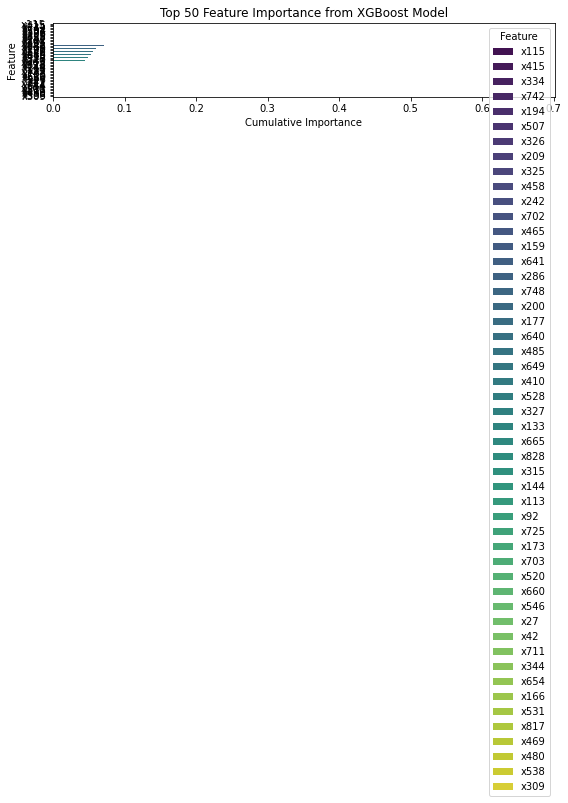

There are 74 features selected.


In [67]:
# Compute feature importance using XGBoost
xgb_importance = xgb_feature_importance(
    n_estimators=200,
    early_stopping_rounds=5,
    X_train=X_train_final,
    y_train=y_train_final,
    n_splits=10,
    eval_metric='rmse',
    verbose=True,
)

# Select important features based on the chosen criteria
X_train_selected, X_test_selected = xgb_feature_select(
    xgb_importance,
    X_train_final,
    X_test_imputed,
    adjust=2,
    criteria='mean',
    verbose=True,
)

In [59]:
# Feature selection using LASSO

# Step 1: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)

# Step 2: Perform LassoCV for Automatic Feature Selection
# LassoCV performs cross-validated selection of the regularization parameter (alpha)
lasso = LassoCV(cv=5, random_state=0, max_iter=10000)
lasso.fit(X_train_scaled, y_train_final)

# Best alpha and model score
print("Best alpha using built-in LassoCV:", lasso.alpha_)
print("Best score using built-in LassoCV:", lasso.score(X_train_scaled, y_train_final))

# Step 3: Extract and Print Selected Features
# Coefficients close to zero will be dropped
coefficients = lasso.coef_
selected_features = np.where(coefficients != 0)[0]

print(f"{len(selected_features)} features selected by Lasso:")

# Step 4: Create New Training Data with Only Selected Features
X_train_selected = X_train_final.iloc[:, selected_features]

c:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.61491074107471, tolerance: 8.658509894736847
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.630991976358928, tolerance: 8.658509894736847
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not con

Best alpha using built-in LassoCV: 0.39900723563937274
Best score using built-in LassoCV: 0.44126762802345065
55 features selected by Lasso:


Use 'SimpleImputer' to impute missing value.


c:\Python\Python310\lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


The shape of X_train: (1187, 833). 
The shape of y_train: (1187, 2).


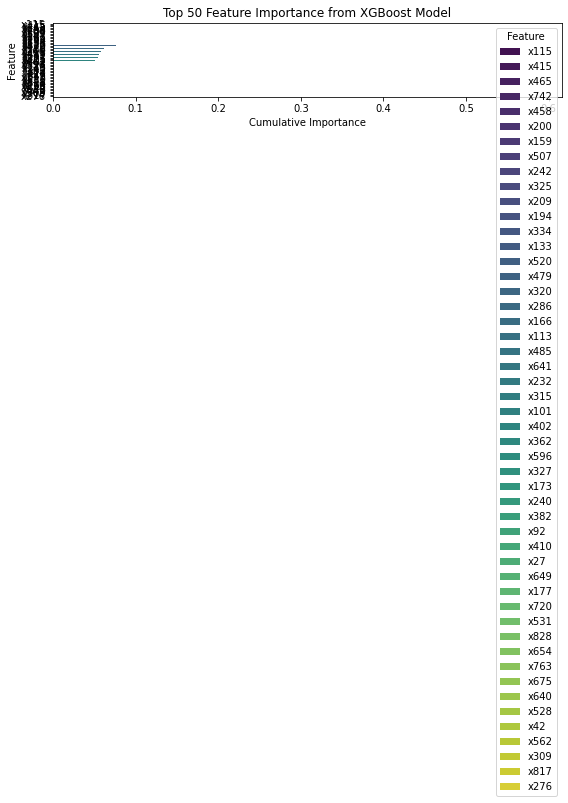

There are 78 features selected.


In [14]:
# X_train, X_test, y_train = preprocess(
#     X_train=X_train_original,
#     X_test=X_test_original,
#     y_train=y_train_original,
#     strategy='median',
#     contamination=0.02,
#     n_estimators=200,
#     early_stopping_rounds=5,
#     n_splits=10,
#     eval_metric="rmse",
#     adjust=2,
#     criteria="mean",
#     verbose=True,
# )

In [27]:
print(np.isnan(X_train).sum(), np.isnan(X_test).sum(), np.isnan(y_train).sum())

NameError: name 'X_train' is not defined

# Model Selection


In [29]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test= scaler.transform(X_test)

Define function for grid search

In [20]:
def gridsearch_best_estimator(estimator, params, X_train, y_train):

    gridsearch = GridSearchCV(estimator=estimator, param_grid=params, scoring='r2', cv=3, n_jobs=-1, verbose=1)
    gridsearch.fit(X_train, y_train)

    print(f"Best parameters for {estimator.__class__.__name__}: {gridsearch.best_params_}")
    print('Score: ', gridsearch.best_score_)

    return gridsearch.best_estimator_

### Set up each model and their parameter grid

Ramdom forest

In [30]:
rf_model = RandomForestRegressor(random_state=0)
rf_parameters = {
    'n_estimators': [1000, 2000, 3000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30]
}
rf_best = gridsearch_best_estimator(rf_model, rf_parameters, X_train, y_train)
joblib.dump(rf_best, 'rf_best.joblib')

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters for RandomForestRegressor: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 3000}
Score:  0.4946363941230784


['rf_best.joblib']

SVM

In [33]:
svr_model = SVR()
svr_parameters = {
    'kernel': ['rbf'],
    'C': np.linspace(50,100,8),
    'epsilon' : np.logspace(-8, -1, 8),
    'gamma': ['scale', 'auto']
}
svr_best = gridsearch_best_estimator(svr_model, svr_parameters, X_train, y_train)
joblib.dump(svr_best, 'svr_best.joblib')

Fitting 3 folds for each of 128 candidates, totalling 384 fits


c:\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters for SVR: {'C': 50.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Score:  0.5005933418018058


['svr_best.joblib']

Gradient boost

In [27]:
gbr_model = GradientBoostingRegressor(random_state=0)
gbr_parameters = {
    'n_estimators': [1000, 2000, 3000],
    'learning_rate': np.logspace(-4, 0, 10),
    'max_depth': [3, 5, 7]
}
gbr_best = gridsearch_best_estimator(gbr_model, gbr_parameters, X_train, y_train)
joblib.dump(gbr_best, 'gbr_best.joblib')

Fitting 3 folds for each of 90 candidates, totalling 270 fits



KeyboardInterrupt



XGBoost

In [34]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=0)
xgb_parameters = {
    'n_estimators': [2000],
    'max_depth': [3, 5, 7],
    'learning_rate': np.logspace(-4, 0, 10)
}
xgb_best = gridsearch_best_estimator(xgb_model, xgb_parameters, X_train, y_train)
joblib.dump(xgb_best, 'xgb_best.joblib')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for XGBRegressor: {'learning_rate': 0.016681005372000592, 'max_depth': 3, 'n_estimators': 2000}
Score:  0.5106358357718374


['xgb_best.joblib']

LightGBM

In [35]:
lgb_model = lgb.LGBMRegressor(random_state=0)
lgb_parameters = {
    'boosting_type': ['gbdt'],
    'n_estimators': [1000],
    'learning_rate': np.logspace(-4, 0, 10),
    'num_leaves': np.logspace(3, 5, 3, base=2).astype(int)
}
lgb_best = gridsearch_best_estimator(lgb_model, lgb_parameters, X_train, y_train)
joblib.dump(lgb_best, 'lgb_best.joblib')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 1187, number of used features: 78
[LightGBM] [Info] Start training from score 69.875316
Best parameters for LGBMRegressor: {'boosting_type': 'gbdt', 'learning_rate': 0.005994842503189409, 'n_estimators': 1000, 'num_leaves': 16}
Score:  0.5025992000388345


['lgb_best.joblib']

CatBoost

In [36]:
cb_model = cb.CatBoostRegressor(verbose=0, random_state=0)
cb_parameters = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': np.logspace(-4, 0, 10)
}
cb_best = gridsearch_best_estimator(cb_model, cb_parameters, X_train, y_train)
joblib.dump(cb_best, 'cb_best.joblib')

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best parameters for CatBoostRegressor: {'depth': 6, 'iterations': 300, 'learning_rate': 0.046415888336127774}
Score:  0.5146414048044726


['cb_best.joblib']

### Combine all models into a stacked regressor

In [37]:
# Load the models 
rf_best = joblib.load('rf_best.joblib')
svr_best = joblib.load('svr_best.joblib')
gbr_best = joblib.load('gbr_best.joblib')
xgb_best = joblib.load('xgb_best.joblib')
lgb_best = joblib.load('lgb_best.joblib')
cb_best = joblib.load('cb_best.joblib')
# Final estimator
final_estimator = Ridge()

# Stacked regressor setup
estimators = [
    ('lgb', lgb_best),
    ('rf', rf_best),
    ('gbr', gbr_best),
    ('svr', svr_best),
    ('xgb', xgb_best),
    ('catboost', cb_best)
]

stacked_regressor = StackingRegressor(estimators=estimators, final_estimator=final_estimator,n_jobs=-1)

# Model

In [68]:
# Initialize KFold
kf = KFold(n_splits=20, shuffle=True, random_state=88)

rmse_scores = []
r2_scores = []
best_r2_score = -np.inf  # Initialize best R² to a very low value
best_model = None  # To store the best model
best_scaler = None  # To store the scaler for the best model

# Loop through each fold
for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_selected), start=1):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_selected.iloc[train_index], X_train_selected.iloc[val_index]
    y_train_fold, y_val_fold = y_train_final.iloc[train_index], y_train_final.iloc[val_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)  # Fit and transform on training data
    X_val_fold = scaler.transform(X_val_fold)

    # Create and fit the model
    
    model = XGBRegressor(
        n_estimators=100000,
        random_state=88,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.85,
        colsample_bytree=0.95,
        early_stopping_rounds=20,
        eval_metric='rmse'
    )

    model.fit(X_train_fold, y_train_fold,
              eval_set=[(X_val_fold, y_val_fold)],
              verbose=False)
    
    # model = stacked_regressor

    # model.fit(X_train_fold, y_train_fold)

    # Predict on the validation set
    y_pred = model.predict(X_val_fold)

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    r2 = r2_score(y_val_fold, y_pred)

    # Print metrics for the current fold
    print(f"Fold {fold_num}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Keep track of the best model based on R² score
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model = model  # Store the model with the best R²
        best_scaler = scaler  # Store the corresponding scaler

# Print the average RMSE and R² across all folds
print(f"\nAverage RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")
print(f"\nBest R² Score: {best_r2_score:.4f}")

# Use the best model and corresponding scaler to predict on X_test
X_test_standardized = best_scaler.transform(X_test_selected)  # Standardize X_test using the best scaler
y_test_pred = best_model.predict(X_test_standardized)

# Print or return the predictions
print("\nPredictions on X_test:")
print(y_test_pred)

Fold 1: RMSE = 5.6657, R² = 0.6282
Fold 2: RMSE = 5.2598, R² = 0.5772
Fold 3: RMSE = 7.3310, R² = 0.3749
Fold 4: RMSE = 6.4178, R² = 0.4832
Fold 5: RMSE = 5.7418, R² = 0.6671
Fold 6: RMSE = 6.2386, R² = 0.6047
Fold 7: RMSE = 5.7884, R² = 0.5743
Fold 8: RMSE = 6.6289, R² = 0.5586
Fold 9: RMSE = 6.1737, R² = 0.5865
Fold 10: RMSE = 6.0760, R² = 0.4319
Fold 11: RMSE = 6.2649, R² = 0.5728
Fold 12: RMSE = 6.0154, R² = 0.5879
Fold 13: RMSE = 5.6067, R² = 0.5816
Fold 14: RMSE = 8.2733, R² = 0.3943
Fold 15: RMSE = 6.6681, R² = 0.5846
Fold 16: RMSE = 6.8254, R² = 0.5720
Fold 17: RMSE = 7.5428, R² = 0.3125
Fold 18: RMSE = 5.4950, R² = 0.5888
Fold 19: RMSE = 5.7454, R² = 0.5809
Fold 20: RMSE = 5.9919, R² = 0.6592

Average RMSE: 6.2875
Average R²: 0.5461

Best R² Score: 0.6671

Predictions on X_test:
[60.540855 76.95699  72.5823   75.64979  73.39771  59.09762  65.38839
 71.26846  69.92804  62.555714 74.60127  75.89246  59.17212  68.77954
 74.36289  66.368286 73.79979  72.63552  65.20278  63.918312 

In [65]:
sample['y'] = y_test_pred
sample.to_csv("submission.csv", index=False)